In [274]:
import numpy as np
import tensorflow as tf
from keras.metrics import Accuracy
import pandas as pd

In [275]:
df = pd.read_csv('Turbine_Data_project.csv')
data = df.copy()
# data = data.sample(frac=1).reset_index(drop=True)

In [276]:
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,WindSpeed,WindDirection,Power
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [277]:
data.describe().transpose()[['mean', 'std']]

,mean,std
WindSpeed,4.703953,3.319007
WindDirection,120.005139,117.987561
Power,496.182282,600.383412


In [278]:
x = tf.cast(data.drop(['Power'], axis=1), tf.float32)
y = tf.cast(data['Power'], tf.float32)

# normalizer = tf.keras.layers.Normalization(input_shape=[2,], axis=None)
# normalizer.adapt(x)

In [279]:
def train_test_split(x, y, train_size=0.8):
    train_size = int(train_size * len(x))
    x_train, x_valid = x[:train_size], x[train_size:]
    y_train, y_valid = y[:train_size], y[train_size:]
    return x_train, x_valid, y_train, y_valid

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9) # 90% train, 10% test
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9) # from train, 90% train, 10% validation

# checking the shapes
print(x_train.shape, x_val.shape, x_test.shape) # x_train[:,0] : wind speed, x_train[:,1] :  wind direction
print(y_train.shape, y_val.shape, y_test.shape) # y_train : power

(95760, 2) (10641, 2) (11823, 2)
(95760,) (10641,) (11823,)


In [280]:
tf.random.set_seed(42)
regularizer = tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)

def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Normalization(input_shape=[2,], variance=1.0, mean=0.0),
        tf.keras.layers.Dense(1024, activation='leaky_relu', input_shape=[2,], kernel_initializer='he_normal',  kernel_regularizer=regularizer),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation='leaky_relu', kernel_initializer='he_normal', kernel_regularizer=regularizer),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, activation='leaky_relu', kernel_initializer='he_normal', kernel_regularizer=regularizer),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='leaky_relu', kernel_initializer='he_normal', kernel_regularizer=regularizer),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(256, activation='leaky_relu', kernel_initializer='he_normal', kernel_regularizer=regularizer),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(128, activation='leaky_relu', kernel_initializer='he_normal', kernel_regularizer=regularizer),
        tf.keras.layers.Dense(1, activation="linear")
    ])
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(lr=0.005, decay=5e-4),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model

model = create_model()
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_31 (Normaliza  (None, 2)                0         
 tion)                                                           
                                                                 
 dense_177 (Dense)           (None, 1024)              3072      
                                                                 
 batch_normalization_108 (Ba  (None, 1024)             4096      
 tchNormalization)                                               
                                                                 
 dropout_112 (Dropout)       (None, 1024)              0         
                                                                 
 dense_178 (Dense)           (None, 512)               524800    
                                                                 
 batch_normalization_109 (Ba  (None, 512)            

/Users/leo/miniforge3/envs/ciri/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [281]:

import os
import datetime
logdir =  '/Users/leo/Documents/IPSA/S9/Deep Learning/PROJET/logs/' + (datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


In [282]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [283]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=10, min_lr=1e-5)

history = model.fit(x_train,
                    y_train,
                    epochs=300,
                    batch_size=2048,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard_callback]) #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

model.save('model.h5')

Epoch 1/100


2022-11-22 22:58:04.106839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - ETA: 0s - loss: 159767.4688 - mean_absolute_error: 240.9960

2022-11-22 22:58:19.657074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 30s 170ms/step - loss: 159767.4688 - mean_absolute_error: 240.9960 - val_loss: 1598507.7500 - val_mean_absolute_error: 1022.1389 - lr: 0.0050
Epoch 2/100
94/94 [==============================] - 10s 104ms/step - loss: 21523.1172 - mean_absolute_error: 69.9211 - val_loss: 43155.3672 - val_mean_absolute_error: 132.2092 - lr: 0.0050
Epoch 3/100
94/94 [==============================] - 9s 92ms/step - loss: 22294.7012 - mean_absolute_error: 70.2568 - val_loss: 20639.8867 - val_mean_absolute_error: 106.7371 - lr: 0.0050
Epoch 4/100
94/94 [==============================] - 9s 95ms/step - loss: 19908.4512 - mean_absolute_error: 63.1556 - val_loss: 15201.2422 - val_mean_absolute_error: 74.8635 - lr: 0.0050
Epoch 5/100
94/94 [==============================] - 8s 85ms/step - loss: 20206.4141 - mean_absolute_error: 63.8254 - val_loss: 20842.8555 - val_mean_absolute_error: 88.7640 - lr: 0.0050
Epoch 6/100
94/94 [==============================] - 9s 90ms/step

In [284]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [Power]')
  plt.legend()
  plt.grid(True)

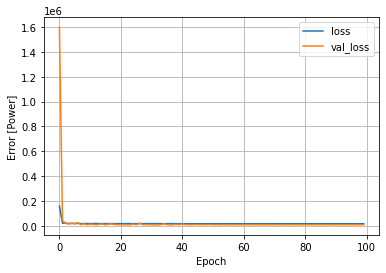

In [285]:
plot_loss(history)

In [312]:
import plotly.graph_objects as go
predicitons = model.predict(x_test)
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=predicitons[:,0], mode='markers', name='predictions'))
fig.add_trace(go.Scatter(x=y_test, y=y_test, mode='lines', name='y=x'))
fig.update_layout(title='Predictions vs y=x', xaxis_title='y_test', yaxis_title='predictions')
fig.show()

370/370 [==============================] - 3s 7ms/step


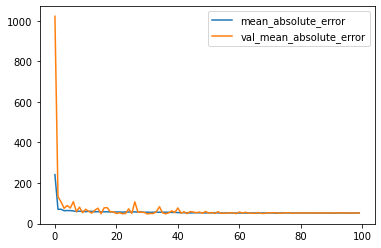

In [287]:
plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'], label = 'val_mean_absolute_error')
plt.legend()
plt.show()